# Building a neural network with numPy

This project shows how to build a simple neural network using just numpy, so the implementation of gradient descent and backpropagation is revealed. Then we'll use it to predict daily bike rentals using [this data set](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = '../data/bikeshare/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. All these features will be incorporaed into the model's predictions.

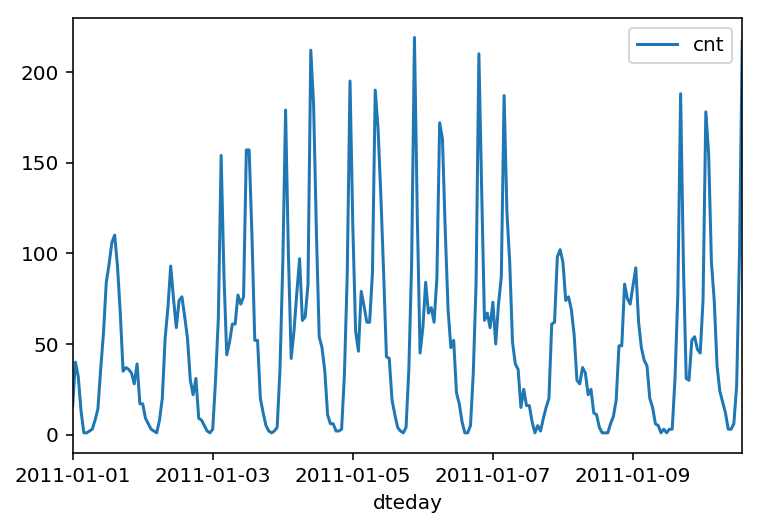

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables using the Pandas function `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

Note how the scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders. Yes, this isn't a good way to divide data, we'll come back to that later. 

In [7]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*. We use the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation.
  

In [9]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

def sigmoid(x):
    return 1/(1+np.exp(-x))


In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        # Activation function is the sigmoid function
        self.activation_function = sigmoid
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        ### Implementation of the Forward pass ###
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        # Output layer
        # calculate signals into final output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        # set signals from final output layer
        final_outputs = final_inputs
 

        ### Implementation of the Backward pass ###
        
        # Output error
        # Output layer error is the difference between desired target and actual output.
        output_errors = targets - final_outputs
        
        # Backpropagated error
        # Calculate hidden layer gradients
        hidden_gradients = (hidden_outputs * (1-hidden_outputs))
        
        # Calculate errors propagated to the hidden layer
        hidden_errors = np.dot(output_errors, self.weights_hidden_to_output)
        
        # Now update the weights
        # First, update hidden-to-output weights with gradient descent step
        # this is learning rate * output_errors (matrix multiply) hidden_outputs.T
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T)
        # Then update input-to-hidden weights with gradient descent step
        # this is learning rate * hidden_errors.T (matrix multipy) inputs.T * hidden_gradients
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors.T, inputs.T) * hidden_gradients

 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [11]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == '../data/bikeshare/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.261s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

Training uses Stochastic Gradient Descent (SGD), where the idea is that for each training pass, we use a random sample of the data instead of the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. There are 3 parameters you might want to play around with:

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [131]:
import sys

np.random.seed(1)

### Set the hyperparameters here ###
epochs = 300
learning_rate = 0.1
hidden_nodes = 59
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)


Progress: 99.6% ... Training loss: 0.089 ... Validation loss: 0.144

The neural network outputs a continuous value: the number of bike hires in an hour period. Thus, this is a regression problem, and so to measure the accuracy achieved, we can calculate the R2 score. The R2 compares our trained model to the simplest possible model - taking the average of all the values, drawing a horizontal line through them, and calculating the mean squared error. Higher is better, with 1 being a perfect predictor.


In [132]:
from sklearn.metrics import r2_score

# generate the predictions with the trained model settings
results = network.run(val_features)

r2 = r2_score(val_targets['cnt'], results[0,])
print ('R2 Score: ', r2.round(3))

R2 Score:  0.888


(-0.15072540759930425, 0.5)

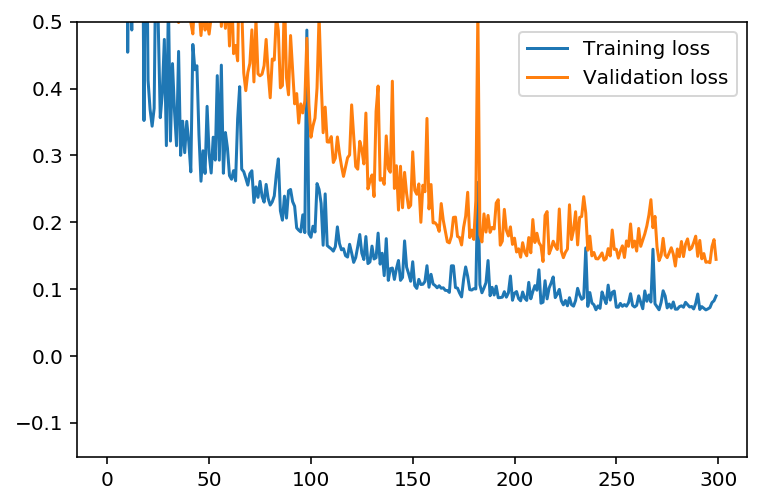

In [133]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

The graph above shows the validation loss following the trend of the training loss, indicating that the model is not overfitting. The number of hidden nodes was based on the maxim of having about the same number of hidden nodes as there are features (there are 59), as described in http://neuralnetworksanddeeplearning.com/chap5.html. There didn't seem to be any benefit in extending the number of epochs past 300. 

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

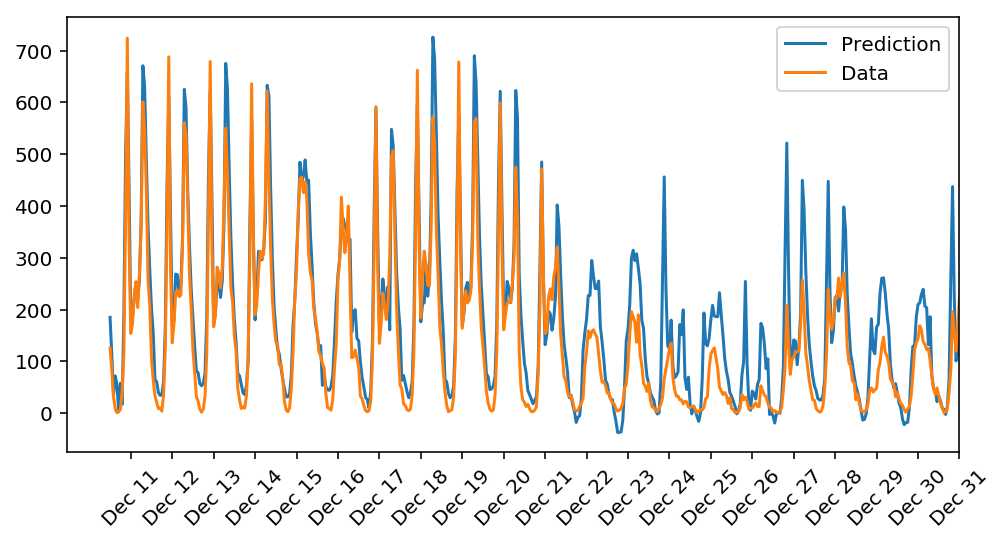

In [84]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Analysis of results
 
Let's consider how well the model predicts the data. Where does it fail? And why does it fail where it does?

For the first 10 days of predictions, the model predicts the actual results observed very accurately. In fact, in some parts of the graph, one line overwrites the other, that's how close the predictions are. 

Where it begins to fail is around December 22nd - when the predicted hires were much higher than what actually occurred. This same over-estimation is then repeated for every subsequent day. The model is particularly inaccurate on December 24th, expecting a surge in demand that never happens. 

The reason why this is occurring is likely to be something we intuitively understand about demand, and which this neural network has not been trained to recognise. The data shows demand for bicycles decreases in the run up to Christmas, probably because regular customers go on holiday. 

But as the model has only been trained on data from January to October, it has never seen any of the seasonal variations that occur around Christmas, and so has never had the chance to learn the pattern of demand found at the end of the year. Although the data does have a holiday field, this isn't sufficient to distinguish between holidays when people might want to get out and cycle, and holidays like Christmas when potential customers are busy doing other things. 

Better accuracy could be achieved by having data for more than one calendar year, and by following the usual cross-validation practice of drawing the training, validation and test sets at random, rather than assigning them in contiguous blocks of months, which are likely to contain seasonal biases. Biases can result in overfitting, because they reduce the model's ability to generalise. 


### So next... try it with scikit-learn's train_test_split

In [138]:
from sklearn.model_selection import train_test_split

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, random_state=0)

np.random.seed(1)

### Set the hyperparameters here ###
epochs = 500
learning_rate = 0.1
hidden_nodes = 59
output_nodes = 1

N_i = X_train.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(X_train.index, size=128)
    for record, target in zip(X_train.ix[batch].values, y_train.ix[batch]['cnt']):
        network.train(record, target)
    
    # Print out the training progress
    train_loss = MSE(network.run(X_train), y_train['cnt'].values)
    val_loss = MSE(network.run(X_test), y_test['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)


Progress: 99.8% ... Training loss: 0.065 ... Validation loss: 0.072

Now, we re-run the predictions with the new model, and measure the accuracy.

In [139]:
# generate the predictions with the trained model settings 
# (scaled up to give true values, although accuracy should be same with scaled values)
mean, std = scaled_features['cnt']
predictions = network.run(X_test)*std + mean
# display the first 5 predictions, this is what we're using to compute the r2 score
for i in range(5):
    print ("Comparing prediction #{0}\t {1:.{digits}f} vs actual: {2:.{digits}f}".format(i, predictions[0,i], y_test.iloc[i]['cnt']*std + mean, digits=2))

r2 = r2_score(y_test['cnt']*std + mean, predictions[0,])
print ('R2 Score: ', r2.round(3))

Comparing prediction #0	 6.72 vs actual: 4.00
Comparing prediction #1	 40.33 vs actual: 89.00
Comparing prediction #2	 91.84 vs actual: 114.00
Comparing prediction #3	 25.31 vs actual: 12.00
Comparing prediction #4	 136.60 vs actual: 139.00
R2 Score:  0.927


Just randomly drawing the train and test data results in a noticeably better r2 score: 92.7% vs 88.8%

Now let's plot the new predictions against the known data, this should provide a better fit, particularly around Christmas time. 

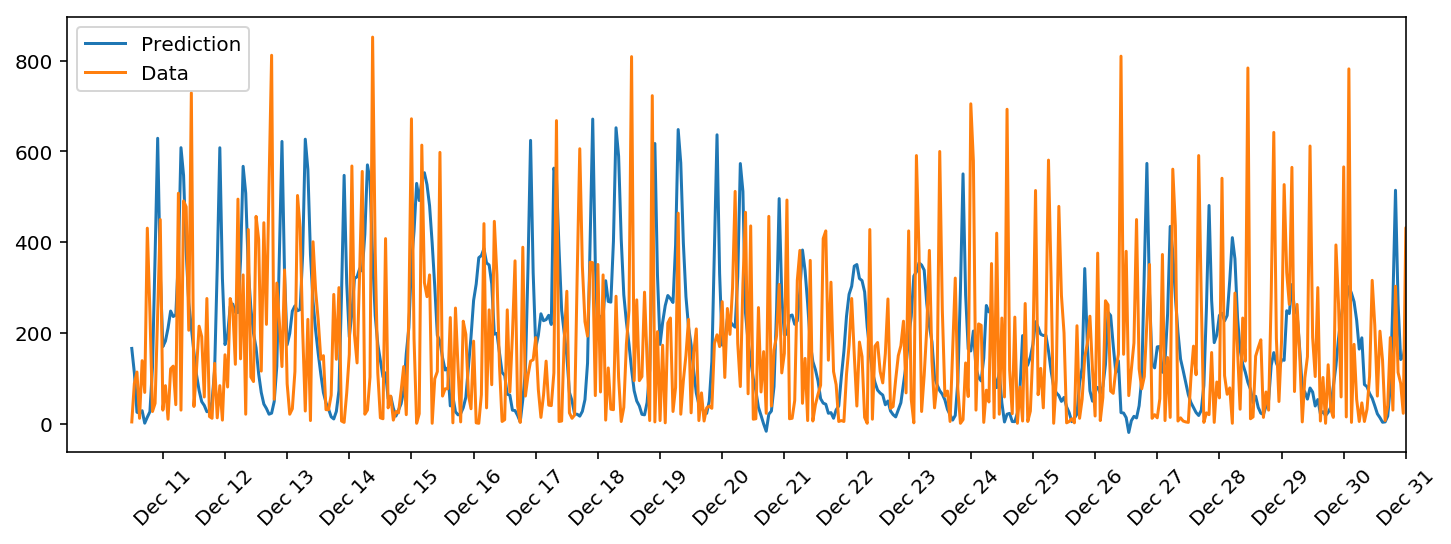

In [142]:
fig, ax = plt.subplots(figsize=(12,4))

# generate predictions with new trained model for just the last 21 days of the year 
predictions = network.run(test_features)*std + mean

mean, std = scaled_features['cnt']
data_points = len(test_data)
ax.plot(predictions[0, :data_points], label='Prediction')
ax.plot((y_test['cnt'][:data_points]*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

The accuracy is still far from perfect of course, but it's worth remembering that achieving ever increasing accuracy becomes more and more challenging. This is especially evident when we reach the predictive limit of the features in our input data - after which, better predictions may require salient factors that are just not represented in our input data. 